# Working with Tabular Data

Although Vibium was designed with vibration waveform data in mind, it still works wonderfully well with non-vibration or KPI data. We refer to this as tabular timeseries data. Each measurement consists of one or more variables captured at the same time. This is different from the vibration waveform data, where each measurement is a short measurement sample from one vibration sensor.

In this example, we will show how to work with tabular sources and measurements, and how to create an analysis. If you have seen any of the previous examples, much of this one will be familiar to you.

## Imports

Beyond importing `MVG` and the `ModeId` analysis class we want to use `pandas` for loading and processing the data before the analysis.

In [1]:
import os
from pprint import pprint
from pathlib import Path

import pandas as pd

from mvg import MVG
from mvg.analysis_classes import ModeId

After importing we create the `MVG` session that let us communicate with the Vibium server. For that we need an endpoint URL and a valid token. If you do not have a token, you can get one [here](https://vikinganalytics.se/multiviz-vibration-api/).

.. note:: Each token is used for Authorization AND Authentication. Thus, each unique token represents a unique user, each user has it own, unique database on the VA vibration' service.

In [2]:
ENDPOINT = "http://api.beta.multiviz.com"
# Replace by your own Token
TOKEN = os.environ['TEST_TOKEN']
session = MVG(ENDPOINT, TOKEN)

We will use a dataset that is collected from a heat pump in the cellar of one of the employees at Viking Analytics. The data is available in [this git repository](https://github.com/vikinganalytics/tabular-example-data). We clone the repository to get access it. If you don't have git you can download the data from the link.


In [3]:
!git clone https://github.com/vikinganalytics/tabular-example-data.git

Cloning into 'tabular-example-data'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 1), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (7/7), 259.90 KiB | 2.03 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [4]:
data_path = Path.cwd() / "tabular-example-data" / "heatpump.csv"
data_df = pd.read_csv(data_path)
data_df.head()

,timestamp,T_out,T_down,T_kitchen,WATT,T_up,T_brine_in,T_brine_out,T_cellar
0,2018-02-01T00:00:00Z,1.976053,38.367181,20.512105,2.780167,40.028018,3.690000,2.068514,10.965206
1,2018-02-01T01:40:00Z,2.380000,36.940000,20.190000,3.045333,39.060000,3.560000,1.991486,10.924431
2,2018-02-01T03:25:00Z,2.211223,37.715920,20.190000,3.060000,39.840240,3.598392,1.961608,10.982982
3,2018-02-01T05:10:00Z,1.964956,37.940000,20.250000,3.151579,40.023789,3.611330,2.068670,10.888049
4,2018-02-01T06:55:00Z,0.349134,37.551293,20.406457,3.257167,39.856860,3.690000,2.120000,10.941380


We loaded the `.csv` file into a dataframe object and printed out the first five rows. The timestamp was read as string timestamps, but for the Vibium API we need the timestamps to be in milliseconds since EPOCH. So we need to do some data wrangling in order to get it to the correct data type.

We can use the function `pandas.to_datetime()` to convert a column into datetime objects. Then we can convert the timestamps into integers, which will automatically get converted to nanoseconds since EPOCH. By dividing by 1e6 we get the same time in milliseconds. We can see that the conversion was successful by printing the first five rows again.

In [5]:
data_df["timestamp"] = pd.to_datetime(data_df["timestamp"]).astype("int64") // 1000000
data_df.head()

/tmp/ipykernel_2219/2491383495.py:1: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  data_df["timestamp"] = pd.to_datetime(data_df["timestamp"]).astype("int64") // 1000000


,timestamp,T_out,T_down,T_kitchen,WATT,T_up,T_brine_in,T_brine_out,T_cellar
0,1517443200000,1.976053,38.367181,20.512105,2.780167,40.028018,3.690000,2.068514,10.965206
1,1517449200000,2.380000,36.940000,20.190000,3.045333,39.060000,3.560000,1.991486,10.924431
2,1517455500000,2.211223,37.715920,20.190000,3.060000,39.840240,3.598392,1.961608,10.982982
3,1517461800000,1.964956,37.940000,20.250000,3.151579,40.023789,3.611330,2.068670,10.888049
4,1517468100000,0.349134,37.551293,20.406457,3.257167,39.856860,3.690000,2.120000,10.941380


To upload the data to the API we need to convert the dataframe into a dictionary on the format {column: values}. Fortunately, dataframes have a method to do just that, called `to_dict()`. It has an argument for changing the orientation of the resulting dictionary. By using `to_dict("list")` we will get it on the correct format. 

.. note:: The dictionary must have a `"timestamp"` key and at least one more column, corresponding to a tracked variable. The `to_dict("list")` method will not include the index, so it is important to have the timestamp as a column in the data and not as an index.

In [6]:
data_dict = data_df.to_dict("list")

Now that the data has been converted to the correct format we are ready to create the source and upload some measurements. When creating a tabular source, you must define the columns that the data will contain ahead of time. This is to prevent arbitrary data to be uploaded to the source. Besides the columns argument, creating a tabular source works the exact same way as creating a waveform source.

In [7]:
session.create_tabular_source(
    sid="heatpump",
    meta={"location": "Molnlycke"},
    columns=data_df.columns.tolist()
)

We can check that the source was uploaded correctly by getting the source information.

In [8]:
source = session.get_source("heatpump")
pprint(source)

{'meta': {'location': 'Molnlycke'},
 'properties': {'columns': ['T_out',
                            'T_down',
                            'T_kitchen',
                            'WATT',
                            'T_up',
                            'T_brine_in',
                            'T_brine_out',
                            'T_cellar'],
                'data_class': 'tabular'},
 'source_id': 'heatpump'}


Next, let's upload the data we prepared to the source

In [9]:
session.create_tabular_measurement(
    sid="heatpump",
    data=data_dict
)

Now that we have a source with measurements we can request an analysis of the data from the server. Requesting analyses for tabular data works the same way as it does for waveform data. Although not all features will work for tabular data. The KPIDemo feature for example will only work with waveform data. Another thing to keep in mind is that when requesting population analyses, all sources to be analyzed simultaneously must have the same data class.

For now we will simply run the mode identification algorithm

In [10]:
response = session.request_analysis(
    sid="heatpump",
    feature="ModeId",
)
request_id = response["request_id"]

To make the results easier to work with we can load them into an analysis class. There exists one for each analysis feature. Once the analysis is finished and we have received the results, we can instatiate the analysis class with the results dictionary.

In [11]:
session.wait_for_analyses([request_id])
results = session.get_analysis_results(request_id)
analysis = ModeId(results)


The analysis class makes it very convenient to view the results. Let's use the `ModeId.plot()` method to get an overview of the results.

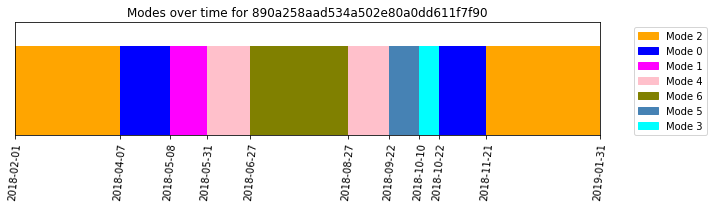

''

In [12]:
analysis.plot()

.. note:: Gray stripes in the plot correspond to gaps in measurements and not a third mode.

When you are finished with the example you can go ahead and delete the source

In [13]:
session.delete_source("heatpump")